# Final Project

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from tqdm import tqdm
import tensorflow.keras as keras
import frame_extractor as extractor
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

2023-11-19 02:19:46.392996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 02:19:46.434929: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_X = []
train_Y = []
parent = os.path.dirname(os.getcwd())
videos = os.listdir(parent + "/train_sample_videos/")
f = open(parent + "/train_sample_videos/metadata.json")
valid = json.load(f)
for video in tqdm(videos):
    if video != "metadata.json":
        for frame in extractor.run_extraction(parent + "/train_sample_videos/" + video):
            train_X.append(frame)
            break
        train_Y.append(1 if valid[video]["label"] == "FAKE" else 0)

100%|██████████| 401/401 [00:44<00:00,  8.93it/s]


In [3]:
def check_orientation(train_X):
    h_sum = 0
    v_sum = 0
    uhoh_sum = 0
    for nar in train_X:
        if(nar.shape==(1920,1080,3)):
            h_sum+=1
        elif(nar.shape==(1080,1920,3)):
            v_sum+=1
        else:
            uhoh_sum+=1


    print(h_sum)
    print(v_sum)
    print(uhoh_sum)

In [4]:
def rotate_vertical(x):
    if x.shape == (1920,1080,3):
        return np.rot90(x)
    else:
        return x

In [5]:
rotated_train_X = list(map(rotate_vertical, train_X))

In [6]:
train_X = rotated_train_X

In [7]:
#Ignore this for now, I don't think we want to filter verticals, 
#but maybe in the future we'll have to, so this code is nice as a failsafe
# def filter_horizontal(x):
#     return x.shape==(1080,1920,3)
# only_horizontal = list(filter(filter_horizontal, train_X))
# check_orientation(only_horizontal)


# Creating the Model
This cell creates the cnn model to be trained. (Currently a basic CNN example model, not our finished model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1078, 1918, 16)    448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 539, 959, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8270416)           0         
                                                                 
 dense_2 (Dense)             (None, 16)                132326672 
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 132,327,154
Trainable params: 132,327,154
Non-trainable params: 0
________________________________________

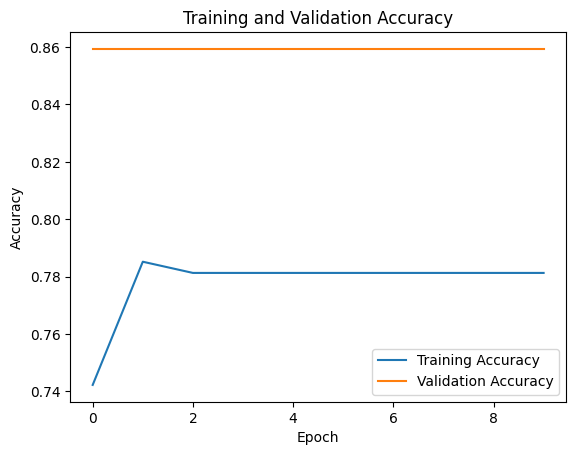

2/2 [==============================] - 4s 2s/step - loss: 0.4292 - accuracy: 0.8594
Validation Accuracy: 85.94%


In [9]:
cnn_epochs = 10
cnn_batch_size = 5
train_samples = len(train_X)
input_shape =  (1080,1920,3) #TODO: Set input_shape to the shape of our input
num_classes = 2

steps_per_epoch = train_samples/cnn_batch_size

# Split the data 
train_X, validation_X, train_Y, validation_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

cnn_model = tensorflow.keras.models.Sequential()
cnn_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(16, activation='relu'))  # Reduce the number of neurons in this layer
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])                     
cnn_model.summary()

train_X = np.array(train_X)
train_Y = np.array(train_Y)

history = cnn_model.fit(train_X, train_Y, epochs=cnn_epochs, batch_size=cnn_batch_size, validation_data=(validation_X, validation_Y))

# Plot for the experiment
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

evaluation = cnn_model.evaluate(validation_X, validation_Y)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")